In [8]:
import json, torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
train_path = "/home/andrew/go_metric/data/go_bench"

train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 256, "collate_fn":collate_seqs}
train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params, num_workers=6)
test_loader = DataLoader(test_dataset, **val_dataloader_params, num_workers=6)

from go_metric.models.bert_emb import ProtBertBFDClassifier
import pickle 
with open("checkpoints/bert_emb_hparams.pkl", "rb") as f:
    hparams = pickle.load(f)
    hparams.num_classes = 865
model = ProtBertBFDClassifier.load_from_checkpoint("checkpoints/bert_emb.ckpt", hparams=hparams)
model.eval()
device = torch.device('cuda:1')
model.to(device)

def get_residue_embeddings(model, dataset, device):
    collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=True)
    dataloader = DataLoader(dataset, collate_fn=collate_seqs, batch_size=128, shuffle=False)
    prot_ids, emb_l, a_l = [], [], []
    with torch.no_grad():
        for inputs in dataloader:
            prot_ids.extend(inputs['prot_id'])
            tokenized_sequences = inputs["seq"].to(device)
            attention_mask = inputs["mask"].to(device)

            word_embeddings = model.ProtBertBFD(tokenized_sequences,
                                           attention_mask)[0]
            emb_l.append(word_embeddings[:, 1:].cpu())
            a_l.append(attention_mask.cpu())
            if(len(prot_ids) % 1024 == 0):
                print(f"{len(prot_ids)*100 / len(dataset)}%")
    embeddings = torch.cat(emb_l, dim=0)
    attention = torch.cat(a_l, dim=0)
    return prot_ids, embeddings, attention

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



-- Encoder model fine-tuning


In [10]:
emb_dataset = [test_dataset[i] for i in range(20)]
prot_ids, embeddings, attention = get_residue_embeddings(model, emb_dataset, device)

In [15]:
residue_embeddings = embeddings[attention[:, 1:]].numpy()
from sklearn.manifold import TSNE
residue_ld = TSNE().fit_transform(residue_embeddings)

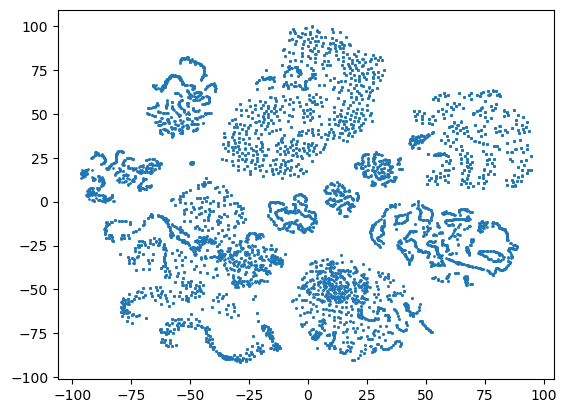

In [17]:
plt.scatter(residue_ld[:, 0], residue_ld[:, 1], s=1)
plt.show()

In [25]:
print(model.classification_head)
residue_cls = model.classification_head(embeddings[attention[:, 1:]].to(device))
print(residue_cls.shape)

Sequential(
  (0): Linear(in_features=1024, out_features=865, bias=True)
)
torch.Size([8753, 865])


In [41]:
head_weights = list(model.classification_head.parameters())[0]
residue_cls = embeddings[attention[:, 1:]].to(device) @ head_weights.T
print(residue_cls.shape)

torch.Size([8753, 865])


In [46]:
residue_cls -= residue_cls.mean(axis=0, keepdim=True)

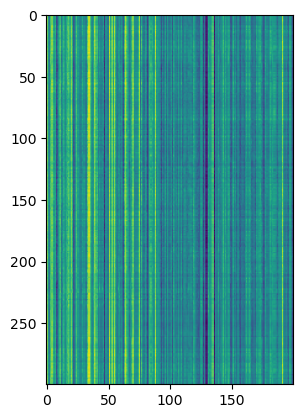

In [49]:
plt.imshow(residue_cls[:300, :200].cpu().detach().numpy())

In [ ]:
cls_head = model.ProtBertBFD.get